In [21]:
%pip install torch transformers numpy matplotlib scikit-learn pandas plotly nbformat

  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached fastjsonschema-2.21.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached jsonschema-4.23.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached jsonschema_specifications-2024.10.1-py3-none-any.whl.metadata (3.0 kB)
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
Using cached fastjsonschema-2.21.1-py3-none-any.whl (23 kB)
Using cached jsonschema-4.23.0-py3-none-any.whl (88 kB)
Using cached jsonschema_specifications-2024.10.1-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [25]:
%pip install --upgrade nbformat

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
import plotly.express as px

# Charger le modèle BERT et son tokenizer depuis HuggingFace
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_embedding(word):
    """
    Cette fonction génère l'embedding du mot donné en entrée en utilisant BERT.
    
    Paramètres :
    word (str) : Le mot dont on veut obtenir l'embedding.

    Retour :
    numpy.ndarray : L'embedding du mot en tant que tableau numpy.
    """
    # 1. Tokenisation du mot (convertir le mot en IDs de tokens pour BERT)
    tokens = tokenizer(word, return_tensors="pt")  # Retourne un dictionnaire avec les 'input_ids' et 'attention_mask'
    
    # 2. Conversion des IDs en tokens lisibles pour l'affichage
    readable_tokens = tokenizer.convert_ids_to_tokens(tokens["input_ids"].squeeze().tolist())

    # 3. Passage du mot dans le modèle BERT pour obtenir les embeddings
    output = model(**tokens)

    print("Mot:", word)
    print("Tokens lisibles:", readable_tokens)
    print("Tokens:", tokens)
    print("Shape de la sortie du modèle:", output.last_hidden_state.shape)  # Forme du tenseur d'embeddings
    print("Embedding du token [CLS] avant déconnexion des gradients:", output.last_hidden_state[:, 0, :].detach())  # extraction de l'embedding du token [CLS] pour chaque exemple dans le batch, retire ce tenseur du graphe de calcul des gradients
    print("\n")

    return output.last_hidden_state[:, 0, :].detach().numpy().flatten()

words = ["king", "woman", "man", "queen"]
embeddings = np.array([get_embedding(word) for word in words])

# Calcul du produit scalaire (dot product) entre les embeddings
def dot_product(A, B):
    """Calculer le produit scalaire entre deux vecteurs A et B"""
    return np.sum(A * B)

# Calcul de la norme d'un vecteur
def norm(A):
    """Calculer la norme (longueur) d'un vecteur A"""
    return np.sqrt(np.sum(A ** 2))

# Calcul de la similarité cosinus entre deux vecteurs A et B
def cosine_similarity_manual(A, B):
    """Calculer la similarité cosinus entre les vecteurs A et B"""
    return dot_product(A, B) / (norm(A) * norm(B))

# Calcul du produit scalaire et de la similarité cosinus pour chaque paire de mots
dot_products = np.zeros((len(words), len(words)))
cosine_similarities = np.zeros((len(words), len(words)))

for i in range(len(words)):
    for j in range(len(words)):
        dot_products[i, j] = dot_product(embeddings[i], embeddings[j])
        cosine_similarities[i, j] = cosine_similarity_manual(embeddings[i], embeddings[j])

# Remplacer les valeurs diagonales par NaN
np.fill_diagonal(dot_products, np.nan)
np.fill_diagonal(cosine_similarities, np.nan)

# Créer un dataframe pour afficher les résultats
df = pd.DataFrame(dot_products, columns=words, index=words)
df_cosine = pd.DataFrame(cosine_similarities, columns=words, index=words)

# Affichage des résultats
print("Produit scalaire (Dot Product) sans diagonale :\n", df)
print("\nSimilarité cosinus (Cosine Similarity) sans diagonale :\n", df_cosine)


# Calculer les indices des paires les plus proches et les plus éloignées
# Dot Product
dot_product_min_idx = np.unravel_index(np.nanargmin(dot_products), dot_products.shape)
dot_product_max_idx = np.unravel_index(np.nanargmax(dot_products), dot_products.shape)

# Cosine Similarity
cosine_min_idx = np.unravel_index(np.nanargmin(cosine_similarities), cosine_similarities.shape)
cosine_max_idx = np.unravel_index(np.nanargmax(cosine_similarities), cosine_similarities.shape)

# Résumé des résultats
print("\nDot Product - Les mots les plus éloignés :", words[dot_product_min_idx[0]], "et", words[dot_product_min_idx[1]], "avec un produit scalaire de", dot_products[dot_product_min_idx])
print("Dot Product - Les mots les plus proches :", words[dot_product_max_idx[0]], "et", words[dot_product_max_idx[1]], "avec un produit scalaire de", dot_products[dot_product_max_idx])

print("\nCosine Similarity - Les mots les plus éloignés :", words[cosine_min_idx[0]], "et", words[cosine_min_idx[1]], "avec une similarité cosinus de", cosine_similarities[cosine_min_idx])
print("Cosine Similarity - Les mots les plus proches :", words[cosine_max_idx[0]], "et", words[cosine_max_idx[1]], "avec une similarité cosinus de", cosine_similarities[cosine_max_idx])

pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(embeddings)

# Création d'un DataFrame pour la visualisation en 3D
df_plot = pd.DataFrame({
    "word": words,
    "x": embeddings_3d[:, 0],
    "y": embeddings_3d[:, 1],
    "z": embeddings_3d[:, 2]
})

# Création du scatter plot 3D avec Plotly Express
fig = px.scatter_3d(df_plot, x="x", y="y", z="z", text="word", 
                      title="Visualisation 3D des Embeddings")
fig.update_traces(textposition='top center')

# Agrandir la hauteur de la fenêtre du graphique
fig.update_layout(height=800)

# Liaison pour la paire la plus proche (selon cosine similarity)
# cosine_max_idx contient les indices des mots les plus proches
closest_idx1, closest_idx2 = cosine_max_idx[0], cosine_max_idx[1]
fig.add_scatter3d(
    x=[embeddings_3d[closest_idx1, 0], embeddings_3d[closest_idx2, 0]],
    y=[embeddings_3d[closest_idx1, 1], embeddings_3d[closest_idx2, 1]],
    z=[embeddings_3d[closest_idx1, 2], embeddings_3d[closest_idx2, 2]],
    mode='lines',
    line=dict(color='green', width=5),
    name='Pair la plus proche'
)

# Liaison pour la paire la plus éloignée (selon cosine similarity)
# cosine_min_idx contient les indices des mots les plus éloignés
farthest_idx1, farthest_idx2 = cosine_min_idx[0], cosine_min_idx[1]
fig.add_scatter3d(
    x=[embeddings_3d[farthest_idx1, 0], embeddings_3d[farthest_idx2, 0]],
    y=[embeddings_3d[farthest_idx1, 1], embeddings_3d[farthest_idx2, 1]],
    z=[embeddings_3d[farthest_idx1, 2], embeddings_3d[farthest_idx2, 2]],
    mode='lines',
    line=dict(color='red', width=5),
    name='Pair la plus éloignée'
)


# Affichage du graphique
fig.show()


Mot: king
Tokens lisibles: ['[CLS]', 'king', '[SEP]']
Tokens: {'input_ids': tensor([[ 101, 2332,  102]]), 'token_type_ids': tensor([[0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1]])}
Shape de la sortie du modèle: torch.Size([1, 3, 768])
Embedding du token [CLS] avant déconnexion des gradients: tensor([[-1.3184e-01,  1.9966e-01,  5.9325e-02,  8.0516e-02, -4.2527e-02,
         -9.0917e-02,  2.8986e-01,  7.0219e-02, -1.7479e-01, -2.3499e-01,
         -7.8909e-02,  4.3450e-02, -3.5087e-02,  2.3391e-01,  2.8623e-01,
          6.7021e-02, -1.9082e-01,  6.6607e-02,  3.2998e-01, -4.6192e-01,
         -5.0473e-02, -1.2404e-01, -1.0474e-01, -2.0417e-01,  1.2156e-01,
         -9.2246e-02, -4.6252e-02, -3.1221e-03,  3.3819e-02,  1.5295e-01,
          3.9030e-02,  2.5014e-01, -1.9153e-01,  1.5212e-01, -8.3758e-02,
         -5.6380e-02,  3.5943e-02, -8.4768e-02, -3.3302e-02,  7.5488e-03,
          1.5911e-01, -6.9021e-02,  1.8661e-01, -3.8404e-02, -1.2238e-01,
         -2.9652e-01, -1.5762e+00, -9.

Mot: king
Tokens: {'input_ids': tensor([[ 101, 2332,  102]]), 'token_type_ids': tensor([[0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1]])}
Sortie du modèle BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.1318,  0.1997,  0.0593,  ..., -0.1656, -0.0187, -0.0151],
         [-0.1006, -0.0524,  0.0772,  ..., -0.2972, -0.1973, -0.6630],
         [ 0.8228,  0.2570, -0.2939,  ..., -0.0014, -0.8282, -0.2063]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-0.7962, -0.2311,  0.4424,  0.6373, -0.3603, -0.1046,  0.8782,  0.1833,
          0.2154, -0.9996,  0.1175,  0.2204,  0.9610, -0.2259,  0.8968, -0.3678,
         -0.1455, -0.4299,  0.3994, -0.7417,  0.5365,  0.8699,  0.6029,  0.1351,
          0.3400,  0.2738, -0.5180,  0.8717,  0.9329,  0.6474, -0.6485,  0.1758,
         -0.9658, -0.2114,  0.3730, -0.9662,  0.1247, -0.7125, -0.0458,  0.0131,
         -0.8082,  0.2329,  0.9899,  0.0665, -0.0993, -0.2937, -0.9993,  0.2260,
         -0.7983, -0.

C:\Users\rapha\AppData\Local\Temp\ipykernel_9504\3714263754.py:73: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



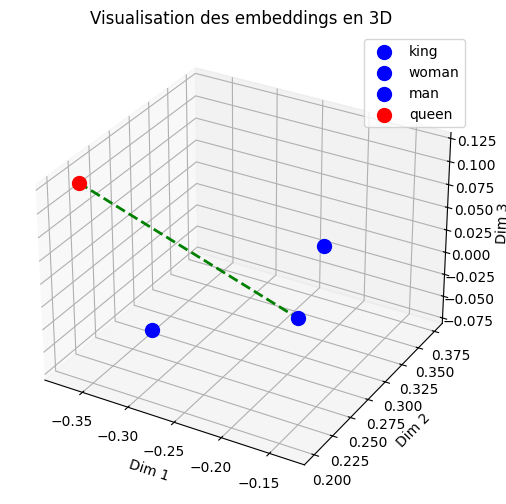

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
from mpl_toolkits.mplot3d import Axes3D

# Charger le modèle BERT et son tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Fonction pour obtenir l'embedding d'un mot
def get_embedding(word):
    tokens = tokenizer(word, return_tensors="pt")
    with torch.no_grad():
        output = model(**tokens)
    return output.last_hidden_state[:, 0, :].numpy().flatten()

# Mots à comparer
words = ["king", "woman", "man", "queen"]
embeddings = np.array([get_embedding(word) for word in words])

# Réduction dimensionnelle (on prend les 3 premières dimensions pour la visualisation)
embeddings_3d = embeddings[:, :3]

# Calcul de la similarité cosinus entre "queen" et les trois autres mots
queen_embedding = embeddings[-1].reshape(1, -1)  # Embedding de "queen"
similarities = cosine_similarity(queen_embedding, embeddings[:-1])

# Trouver le mot le plus proche
closest_idx = np.argmax(similarities)
closest_word = words[closest_idx]

# Affichage des similarités
for i, word in enumerate(words[:-1]):
    print(f"Similarité entre 'queen' et '{word}': {similarities[0][i]:.4f}")

print(f"\nLe mot le plus proche de 'queen' est '{closest_word}' avec une similarité de {similarities[0][closest_idx]:.4f}")

# --- AFFICHAGE 3D ---
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Affichage des points
for i, word in enumerate(words):
    color = "red" if word == "queen" else "blue"
    ax.scatter(*embeddings_3d[i], color=color, label=word, s=100)

# Relier "queen" au mot le plus proche
ax.plot([embeddings_3d[-1, 0], embeddings_3d[closest_idx, 0]], 
        [embeddings_3d[-1, 1], embeddings_3d[closest_idx, 1]], 
        [embeddings_3d[-1, 2], embeddings_3d[closest_idx, 2]], 
        color="green", linestyle="dashed", linewidth=2)

# Légendes
ax.set_xlabel("Dim 1")
ax.set_ylabel("Dim 2")
ax.set_zlabel("Dim 3")
ax.legend()
ax.set_title("Visualisation des embeddings en 3D")

plt.show()

In [ ]:
%pip install langchain
%pip install langchain-core
%pip install langchain_community
%pip install sentence-transformers

In [ ]:
import os
import time
import ollama
import chromadb
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from sentence_transformers import SentenceTransformer

question = "What kinds of pets do I like?"
document = "My favorite pet is a cat."

def load_embedding_model(model_name="sentence-transformers/all-MiniLM-L6-v2"):
    """
    Load the embedding model for text vectorization.
    :param model_name: Name of the SentenceTransformer model to load.
    :return: Loaded embedding model instance.
    """
    print(f"[INFO] Loading embedding model: {model_name}")
    start_time = time.time()
    model = SentenceTransformer(model_name)
    elapsed_time = time.time() - start_time
    print(f"[SUCCESS] Embedding model loaded. {elapsed_time:.2f}s")
    return model

def create_embeddings(model, text_chunks):
    """
    Generate embeddings for text chunks.
    :param model: Embedding model.
    :param text_chunks: List of text chunks.
    :return: List of embeddings.
    """
    print("[INFO] Generating embeddings...")
    start_time = time.time()
    embeddings = model.encode(text_chunks).tolist()
    elapsed_time = time.time() - start_time
    print(f"[SUCCESS] Generated {len(embeddings)} embeddings in {elapsed_time:.2f}s")
    return embeddings



model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
hf_embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)
query_result = hf_embeddings.embed_query(question)
document_result = hf_embeddings.embed_query(document)
len(query_result)


import numpy as np

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

similarity = cosine_similarity(query_result, document_result)
print("Cosine Similarity:", similarity)

In [11]:
# Requires !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device="cpu") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

single_sentence = "Yo! How cool are embeddings?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

No sentence-transformers model found with name sentence-transformers/all-mpnet-base-v2. Creating a new one with mean pooling.


KeyboardInterrupt: 

In [ ]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

### Embedding our text chunks

BPE tokeniser
Unsupervised text tokenizer for Neural Network-based text generation.


While humans understand text, machines understand numbers best.

An [embedding](https://vickiboykis.com/what_are_embeddings/index.html) is a broad concept.

But one of my favourite and simple definitions is "a useful numerical representation".

The most powerful thing about modern embeddings is that they are *learned* representations.

Meaning rather than directly mapping words/tokens/characters to numbers directly (e.g. `{"a": 0, "b": 1, "c": 3...}`), the numerical representation of tokens is learned by going through large corpuses of text and figuring out how different tokens relate to each other.

Ideally, embeddings of text will mean that similar meaning texts have similar numerical representation.

> **Note:** Most modern NLP models deal with "tokens" which can be considered as multiple different sizes and combinations of words and characters rather than always whole words or single characters. For example, the string `"hello world!"` gets mapped to the token values `{15339: b'hello', 1917: b' world', 0: b'!'}` using [Byte pair encoding](https://en.wikipedia.org/wiki/Byte_pair_encoding) (or BPE via OpenAI's [`tiktoken`](https://github.com/openai/tiktoken) library). Google has a tokenization library called [SentencePiece](https://github.com/google/sentencepiece).

Our goal is to turn each of our chunks into a numerical representation (an embedding vector, where a vector is a sequence of numbers arranged in order).

Once our text samples are in embedding vectors, us humans will no longer be able to understand them.

However, we don't need to.

The embedding vectors are for our computers to understand.

We'll use our computers to find patterns in the embeddings and then we can use their text mappings to further our understanding.

Enough talking, how about we import a text embedding model and see what an embedding looks like.

To do so, we'll use the [`sentence-transformers`](https://www.sbert.net/docs/installation.html) library which contains many pre-trained embedding models.

Specifically, we'll get the `all-mpnet-base-v2` model (you can see the model's intended use on the [Hugging Face model card](https://huggingface.co/sentence-transformers/all-mpnet-base-v2#intended-uses)).

### Chunking and embedding questions

> **Which embedding model should I use?**

This depends on many factors. My best advice is to experiment, experiment, experiment! 

If you want the model to run locally, you'll have to make sure it's feasible to run on your own hardware. 

A good place to see how different models perform on a wide range of embedding tasks is the [Hugging Face Massive Text Embedding Benchmark (MTEB) Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

> **What other forms of text chunking/splitting are there?**

There are a fair few options here too. We've kept it simple with groups of sentences.

For more, [Pinecone has a great guide on different kinds of chunking](https://www.pinecone.io/learn/chunking-strategies/) including for different kinds of data such as markdown and LaTeX.

Libraries such as [LangChain also have a good amount of in-built text splitting options](https://python.langchain.com/docs/modules/data_connection/document_transformers/).

> **What should I think about when creating my embeddings?**

Our model turns text inputs up to 384 tokens long in embedding vectors of size 768.

Generally, the larger the vector size, the more information that gets encoded into the embedding (however, this is not always the case, as smaller, better models can outperform larger ones).

Though with larger vector sizes comes larger storage and compute requirements.

Our model is also relatively small (420MB) in size compared to larger models that are available.

Larger models may result in better performance but will also require more compute.

So some things to think about:
* Size of input - If you need to embed longer sequences, choose a model with a larger input capacity.
* Size of embedding vector - Larger is generally a better representation but requires more compute/storage.
* Size of model - Larger models generally result in better embeddings but require more compute power/time to run.
* Open or closed - Open models allow you to run them on your own hardware whereas closed models can be easier to setup but require an API call to get embeddings.

> **Where should I store my embeddings?**

If you've got a relatively small dataset, for example, under 100,000 examples (this number is rough and only based on first hand experience), `np.array` or `torch.tensor` can work just fine as your dataset.

But if you've got a production system and want to work with 100,000+ embeddings, you may want to look into a [vector database]( https://en.wikipedia.org/wiki/Vector_database) (these have become very popular lately and there are many offerings).

### Document Ingestion and Embedding Creation Extensions

One major extension to the workflow above would to functionize it.

Or turn it into a script.

As in, take all the functionality we've created and package it into a single process (e.g. go from document -> embeddings file).

So you could input a document on one end and have embeddings come out the other end. The hardest part of this is knowing what kind of preprocessing your text may need before it's turned into embeddings. Cleaner text generally means better results.
